<a href="https://colab.research.google.com/github/coldfir3/KAGGLE-SETI/blob/main/Seti%20V3.0%20(siamese).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules
!nvidia-smi

Mon Aug 16 00:10:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing packages

In [2]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

### Loading packages

In [3]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
from argparse import Namespace
import timm

### Downloading data



In [4]:
wandb.Api()
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/setispatialdatasetv2-off')
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v2')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv

## Setting up the DataFrames

In [5]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    pass
    # train_study = pd.read_csv('/media/passos/Data/DSET/siim-covid19-detection/train_study_level.csv')

train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.png')
train_df['path_off'] = train_df['id'].apply(lambda x: base_path[:-1] + '_off/' + x + '.png')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df

,id,target,fold,path,path_off
0,0000799a2b2c42d,0,3,/content/train/0000799a2b2c42d.png,/content/train_off/0000799a2b2c42d.png
1,00042890562ff68,0,3,/content/train/00042890562ff68.png,/content/train_off/00042890562ff68.png
2,0005364cdcb8e5b,0,4,/content/train/0005364cdcb8e5b.png,/content/train_off/0005364cdcb8e5b.png
3,0007a5a46901c56,0,3,/content/train/0007a5a46901c56.png,/content/train_off/0007a5a46901c56.png
4,0009283e145448e,0,3,/content/train/0009283e145448e.png,/content/train_off/0009283e145448e.png
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/content/train/fff8217fe05aba3.png,/content/train_off/fff8217fe05aba3.png
59996,fffa939e610ed70,0,4,/content/train/fffa939e610ed70.png,/content/train_off/fffa939e610ed70.png
59997,fffbb1c9c3d6c31,1,5,/content/train/fffbb1c9c3d6c31.png,/content/train_off/fffbb1c9c3d6c31.png
59998,fffc9a763d23647,0,0,/content/train/fffc9a763d23647.png,/content/train_off/fffc9a763d23647.png


## DataBlock & DataLoader

In [6]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImageBW.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], 10, t1.shape[2])
        return show_image(torch.cat([t1,line,t2], dim=1), ctx=ctx, **kwargs)

def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

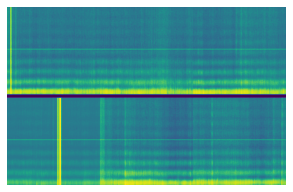

In [7]:
row = train_df[train_df['target'] == 1].iloc[0]
img = ImageTuple.create((row['path'], row['path_off']))
img = ToTensor()(img)
img.show();

In [8]:
import albumentations as A
class AlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
tfms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(rotate_limit=0, p=.25),
        A.MotionBlur(p=.2),
        A.IAASharpen(p=.25)
])

In [9]:
def get_tuples(files): return [ColReader('path')(files), ColReader('path_off')(files)]
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageTupleBlock, CategoryBlock),
        splitter = splitter,
        getters=[get_tuples, ColReader('target')],
        item_tfms=AlbumentationsTransform(tfms),
        batch_tfms=[Flip(), Normalize(mean = tensor(0.5), std = tensor(0.177))]
        ).dataloaders(df, bs = config['bs'], num_workers = workers)

dls = get_dls(train_df, **{'bs':8, 'fold':0})
# dls.show_batch(figsize=(2,2))

In [10]:
# https://arxiv.org/pdf/2103.09950.pdf
# https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb

class ResBlock(nn.Module):
    def __init__(self,num_channels=16):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.leakyrelu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        
        return out

def make_block(r,n):
    residual = []
    
    for i in range(r):
        block = ResBlock(num_channels=n)
        residual.append(block)
    
    return nn.Sequential(*residual)

class ResizingNetwork(nn.Module):
    def __init__(self, img_size, in_chans = 3, r=1, n=16):
        super(ResizingNetwork, self).__init__()

        self.img_size = img_size
        
        self.conv1 = nn.Conv2d(in_channels=in_chans,out_channels=n,kernel_size=7,stride=1,padding=3)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(n,n,kernel_size=1,stride=1)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        self.bn1 = nn.BatchNorm2d(n)
                
        self.resblock = make_block(r,n)        
        
        self.conv3 = nn.Conv2d(n,n,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n,out_channels=in_chans,kernel_size=7,stride=1,padding=3)
        
    def forward(self, x):
        
        residual = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.conv1(x)
        out = self.leakyrelu1(out)
        
        out = self.conv2(out)
        out = self.leakyrelu2(out)
        out = self.bn1(out)
        
        out_residual = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.resblock(out_residual)
        
        out = self.conv3(out)
        out = self.bn2(out)
        out += out_residual
        
        out = self.conv4(out)
        out += residual
        
        return out

In [11]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1, x2 = x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

def create_timm_model_siamese(**cfg):
    model_name = cfg.pop('arch')
    
    if 'img_size' in cfg.keys():
        img_size = cfg.pop('img_size')
        res = ResizingNetwork(img_size, cfg['in_chans'])
    else:
        img_size = 224
        res = Identity()
    body = timm.create_model(model_name, True, num_classes = 0, **cfg)
    body = nn.Sequential(res, body)

    ## head
    nf = body(torch.randn((2, cfg['in_chans'], img_size,img_size))).shape[-1]
    # head = create_head(nf*2, 1, ps=0.5)
    head = nn.Linear(2*nf, 1)

    # SiameseModel(body)
    model = SiameseModel(body, head)

    return model

model = create_timm_model_siamese(**{
    # 'arch':'swin_large_patch4_window7_224',
    'arch':'resnet18',
    'img_size':224,
    'in_chans' : 1, 
})
# model
# model(torch.randn(2,1,300,400), torch.randn(2,1,300,400))
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [13]:
class wandb_learner():

    def __init__(self, df, **config):

        cbs = []
        if config['Fit']['n_epoch'] < 1:
            df = df.sample(frac=config['Fit']['n_epoch']).reset_index(drop=True)
            config['Fit']['n_epoch'] = 1
            
        self.df = df
        self.config = config

        self.dls = get_dls(df, **config['Dataloader'])
        self.model = create_timm_model_siamese(**config['Model'])
        self.learn = Learner(self.dls, self.model, **config['Learner']).add_cbs(cbs)

        self.scheduler = self.config['Fit'].pop('scheduler')
        self.wandb_config = self.config.pop('WandB')

    def unfrozen_count(self):
        return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, self.model.parameters())])

    def fit(self):

        if self.scheduler == 'fine_tune':

            lr_max  = self.config['Fit'].pop('lr_max')
            n_epoch = self.config['Fit'].pop('n_epoch')
            freeze_lr = self.config['Fit'].pop('freeze_lr')
            freeze_epochs = self.config['Fit'].pop('freeze_epochs')
            lr_mult = self.config['Fit'].pop('lr_mult')
            lr = slice(lr_max/lr_mult, lr_max)

            self.learn.freeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(freeze_epochs, slice(freeze_lr), pct_start=0.99, **self.config['Fit'])

            self.learn.unfreeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(n_epoch - freeze_epochs, lr, pct_start=0.3, div=5.0, **self.config['Fit'])    
            
            self.config['Fit']['lr_max'] = lr_max
            self.config['Fit']['n_epoch'] = n_epoch
            self.config['Fit']['freeze_lr'] = freeze_lr
            self.config['Fit']['freeze_epochs'] = freeze_epochs
            self.config['Fit']['lr_mult'] = lr_mult
            
        elif self.scheduler == 'one_cycle': 
          print(f'Training {self.unfrozen_count()} parameters ...')
          self.learn.fit_one_cycle(**self.config['Fit'])

        elif self.scheduler == 'cossine': print('not implemented')

        elif self.scheduler == 'reduce_on_plateau': print('not implemented')

        else: self.learn.fit(**self.config['Fit'])

    def wandb_fit(self):
        
        with wandb.init(config = self.config, **self.wandb_config) as run:
            self.learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
            self.learn.add_cb(SaveAndLogBestModel())
            self.fit()

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['resnet', 'SIAMESE'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'bs' : 16,
        'fold' : 0, 
    },
    'Model' : {
        'arch':'swin_tiny_patch4_window7_224',
        'img_size':224,
        'in_chans' : 1,
    },
    'Learner' : {
        'loss_func' : BCEWithLogitsLossFlat(),
        'metrics' : RocAucMulti(),
        'cbs' : [
                #  GradientAccumulation(8192//8),
                #  MixUp()
                ],
        'splitter' : siamese_splitter
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 0.001,
        'n_epoch' : 10,
        'freeze_lr' : 0.002,
        'freeze_epochs' : 1,
        'lr_mult' : 100,
    }
}

learn = wandb_learner(train_df, **CFG)
# learn.learn.lr_find()
learn.wandb_fit()
# learn.fit()

wandb: Currently logged in as: coldfir3 (use `wandb login --relogin` to force relogin)


Training 26433 parameters ...
Could not gather input dimensions


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.335793,0.320907,0.569859,19:52


Better model found at epoch 0 with valid_loss value: 0.3209066689014435.
Training 27526764 parameters ...
Could not gather input dimensions


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.266015,0.248505,0.745249,26:47


Better model found at epoch 0 with valid_loss value: 0.24850483238697052.


In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['resnet', 'SIAMESE'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'bs' : 32,
        'fold' : 0, 
    },
    'Model' : {
        'arch':'resnet18',
        'img_size':224,
        'in_chans' : 1,
    },
    'Learner' : {
        'loss_func' : BCEWithLogitsLossFlat(),
        'metrics' : RocAucMulti(),
        'cbs' : [
                #  GradientAccumulation(8192//8),
                #  MixUp()
                ],
        'splitter' : siamese_splitter
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 0.001,
        'n_epoch' : 10,
        'freeze_lr' : 0.002,
        'freeze_epochs' : 1,
        'lr_mult' : 100,
    }
}

# learn = wandb_learner(train_df, **CFG)
# # learn.learn.lr_find()
# learn.wandb_fit()
# # learn.fit()